In [1]:
from IPython.display import HTML

%run ../_setup.py

import numpy as np
import datetime
import pyproj

from netCDF4 import Dataset, num2date
from OceanPy.animations import play2D

from gsw import f

%matplotlib notebook
import matplotlib.pyplot as plt

import cmocean as cmo

In [2]:
input_file = os.path.join(datadir, 'external', 'ssh', 'SSH_OceanCurrent_137_-52.4_147_-48_199801-199804.nc')
ssh = Dataset(input_file)

loni, lati = ssh['LONGITUDE'][:], ssh['LATITUDE'][:]
lonlon, latlat = np.meshgrid(loni, lati)

UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
xx, yy = pyproj.transform(WGS84, UTM54, lonlon, latlat)

time = ssh['TIME']
time = num2date(time[:], time.units)
begin = datetime.datetime(1998, 3, 10)
end = datetime.datetime(1998, 3, 28)

np.where(time==begin)

timevoy = np.array([begin <= t <= end for t in time])

V = np.ma.masked_all(ssh['UCUR'].shape)
zeta, div = V.copy(), V.copy()
for t in range(len(time)):
    V[t,] = np.sqrt(ssh['UCUR'][t,]**2 + ssh['VCUR'][t,]**2)
    dvdx = np.gradient(ssh['VCUR'][t,])[1] / np.gradient(xx)[1]
    dudy = np.gradient(ssh['UCUR'][t,])[0] / np.gradient(yy)[0]
    
    dudx = np.gradient(ssh['UCUR'][t,])[0] / np.gradient(xx)[1]
    dvdy = np.gradient(ssh['VCUR'][t,])[1] / np.gradient(yy)[0]

    zeta[t,] = dvdx - dudy
    div[t,] = dudx + dvdy

# Absolute vorticity
planet_vort = f(latlat)

# Dynamic Height over time of the voyage
D = np.mean(ssh['GSL'][timevoy], axis=0)


In [13]:
ssh['GSLA']

<class 'netCDF4._netCDF4.Variable'>
float64 GSLA(TIME, LATITUDE, LONGITUDE)
    long_name: gridded (adjusted) sea level anomaly 
    standard_name: sea_surface_height_above_sea_level
    description: Altimeter and tidegauge estimates of adjusted sea level anomaly mapped onto a grid using optimal interpolation (OI). For details of  the temporal and spatial covariance functions of the OI see the Reference. The anomaly field is mapped because the geoid is not known to sufficient precision, obliging us to remove the time-mean from all sea level observations. Sea level minus the tides and inverse barometer (IB) response, rather than total sea level, is mapped because it is the quantity from which geostrophic velocities can be estimated, and because total sea level has too much high-frequency energy to be mapped from altimeter data anyway.  To de-alias the altimeter data, we have subtracted the estimates provided by the space agencies of the various high frequency signals, evaluated at the s

In [4]:
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

anim = play2D(loni, lati, V, time=time, mask=timevoy, cmin=0, cmax=0.6, cmap=cmo.cm.speed, interval=200, 
              save=True, savepath=os.path.join(outdir, 'ss9802'))
display_animation(anim)

Provide filename for animation: ssh_flow_speed.mp4


In [5]:
anim = play2D(loni, lati, zeta, time=time, mask=timevoy, cmin=-2e-5, cmax=2e-5, cmap=cmo.cm.balance, interval=200)
display_animation(anim)

In [6]:
anim = play2D(loni, lati, div, time=time, mask=timevoy, cmin=-1.5e-5, cmax=1.5e-5, cmap=cmo.cm.delta, interval=200)
display_animation(anim)

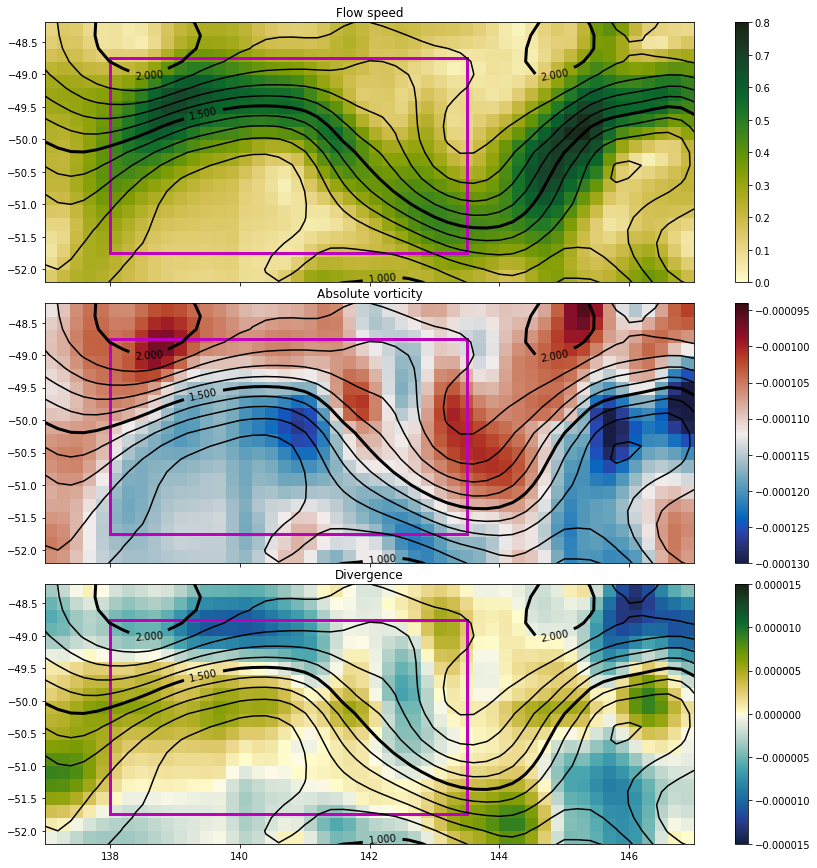

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
fig.tight_layout()

# plot flow speed field
vmin, vmax = 0, 0.8
axis=0
pcol = ax[axis].pcolor(loni, lati, np.mean(V[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.speed)
plt.colorbar(pcol, ax=ax[axis])
ax[axis].set_title('Flow speed')

# # plot relative vorticity field
# vmin, vmax = -2e-5, 2e-5
axis=1
# pcol = ax[axis].pcolor(loni, lati, np.mean(zeta[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
# plt.colorbar(pcol, ax=ax[axis])
# ax[axis].set_title('Relative vorticity')

# plot absolute vorticity field
# vmid= -1.12e-4 # f(-50.2)
vmin, vmax = -0.94e-4, -1.3e-4
axis=1
pcol = ax[axis].pcolor(loni, lati, planet_vort + np.mean(zeta[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.balance)
plt.colorbar(pcol, ax=ax[axis])
ax[axis].set_title('Absolute vorticity')

# plot divergence field
vmin, vmax = -1.5e-5, 1.5e-5
axis=2
pcol = ax[axis].pcolor(loni, lati, np.mean(div[timevoy], axis=0), vmin=vmin, vmax=vmax, cmap=cmo.cm.delta)
plt.colorbar(pcol, ax=ax[axis])
ax[axis].set_title('Divergence')

bounds = np.linspace(1, 2, 11)
for i in range(len(ax)):
    
    # plot dynamic height contours
    ct = ax[i].contour(loni, lati, np.mean(ssh['GSL'][timevoy], axis=0), bounds, colors='k')
    for ib, b in enumerate(bounds):
        if b in bounds[0::5]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=3)
    ax[i].clabel(ct, bounds[0::5], inline=1, fontsize=10)
    
    # plot observations domain
    ax[i].fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
               facecolor='none', edgecolor='m', linewidth=3)
    
    ax[i].set_aspect('equal')

fig.savefig(os.path.join(outdir, 'ss9802', 'altimetry.png'), transparent=True)#, bbox_inches='tight'

## Hovmoller diagram

137.0
142.6


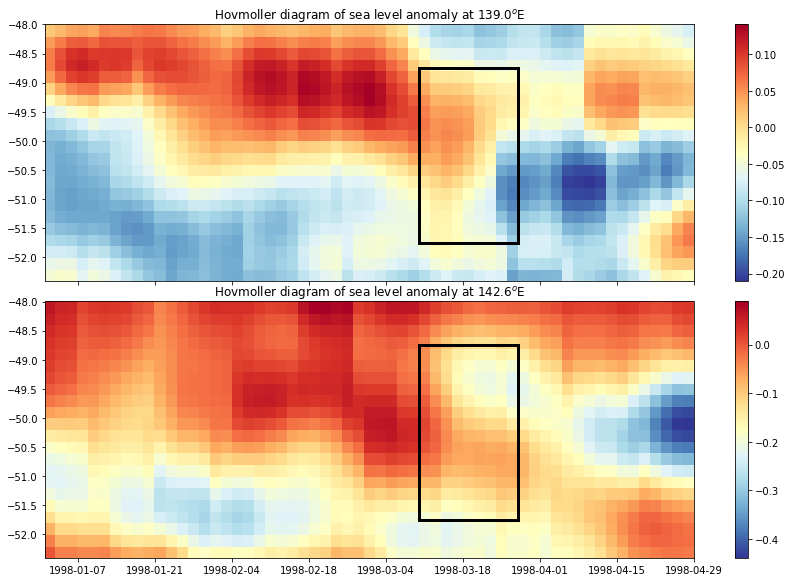

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.tight_layout()
pcol = ax[0].pcolormesh(time, ssh['LATITUDE'], ssh['GSLA'][:,:,10].T, cmap=plt.cm.RdYlBu_r)
print(ssh['LONGITUDE'][10])
plt.colorbar(pcol, ax=ax[0])
ax[0].set_title(r'Hovmoller diagram of sea level anomaly at %s$^o$E' % ssh['LONGITUDE'][10])

# plot observations domain
tbeg, tend = time[np.where(time==begin)[0]], time[np.where(time==end)[0]]
ax[0].fill([tbeg, tend, tend, tbeg], [-51.75, -51.75, -48.75, -48.75], facecolor='none', edgecolor='k', linewidth=3)

pcol = ax[1].pcolormesh(time, ssh['LATITUDE'], ssh['GSLA'][:,:,28].T, cmap=plt.cm.RdYlBu_r)
print(ssh['LONGITUDE'][28])
plt.colorbar(pcol, ax=ax[1])
ax[1].fill([tbeg, tend, tend, tbeg], [-51.75, -51.75, -48.75, -48.75], facecolor='none', edgecolor='k', linewidth=3)
ax[1].set_title(r'Hovmoller diagram of sea level anomaly at %s$^o$E' % ssh['LONGITUDE'][28])

fig.savefig(os.path.join(outdir, 'ss9802', 'hovmoller_gsla.png'), transparent=True)#, bbox_inches='tight'